In [1]:
from train import train
from data import initialize_loader, Flickr8k
from encoder_decoder import ResNetEncoder, Decoder, DecoderWithAttention, ResNetAttentionEncoder
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
import random
import os
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
args = AttrDict()
# You can play with the hyperparameters here, but to finish the assignment,
# there is no need to tune the hyperparameters here.
args_dict = {
    "embed_size": 256,
    "hidden_size": 512,
    "encoder_dim": 512, # MUST MATCH THE RESNET ENCODER OUTPUT
    "attention_dim": 256,
    "learn_rate": 0.002,
    "batch_size": 32,
    "epochs": 5,
    "log_step": 25,
    "save_epoch": 1,
    "model_path": "models/",
    "load_model": False,
    "encoder_path": "models/encoder-attention-5.ckpt",
    "decoder_path": "models/decoder-attention-5.ckpt",
    "model_type": "attention"
}
args.update(args_dict)

In [4]:
train(args)

In [5]:
with open("vocab.pkl", 'rb') as f:
        vocab = pickle.load(f)
        
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            ])

train_data = Flickr8k(csv_file="flickr8k/train.csv", root_dir="flickr8k/images", vocab=vocab, transform=transform)
train_loader = initialize_loader(train_data, batch_size=args.batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

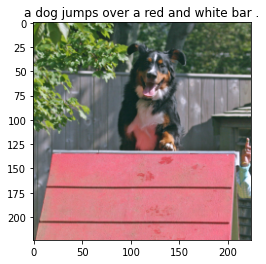

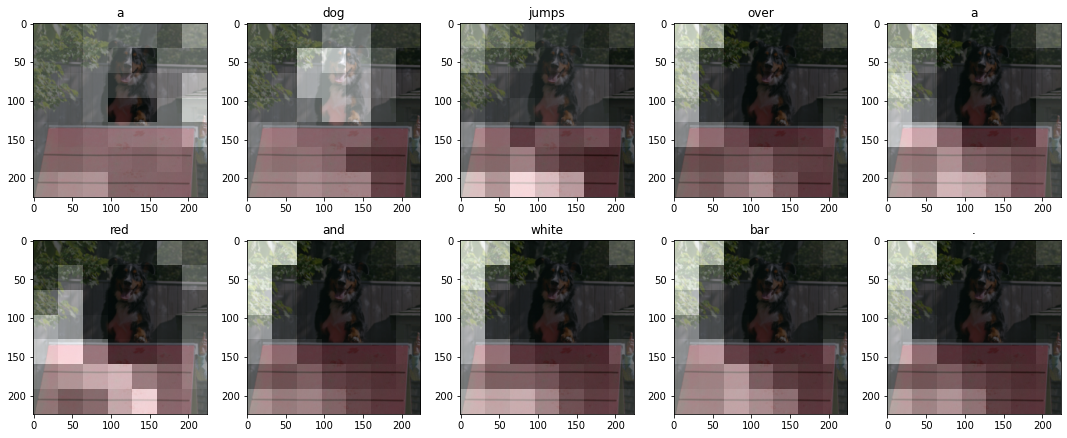

In [15]:
if args.model_type == "attention":
    e = ResNetAttentionEncoder(args.embed_size)
    d = DecoderWithAttention(len(
        vocab), args.embed_size, args.hidden_size, args.encoder_dim, args.attention_dim)
else:
    e = ResNetEncoder(args.embed_size)
    d = Decoder(len(vocab), args.embed_size, args.hidden_size)

if args.load_model:
    e.load_state_dict(torch.load(args.encoder_path))
    d.load_state_dict(torch.load(args.decoder_path))

e.to(device)
d.to(device)

rand_num = random.randint(0, 8000)
img = train_data[rand_num][0]
if args.model_type == "attention":
    caps, alphas = get_caption_attention(e, d, img, vocab)
    plot_attention(img, caps, alphas)
else:
    caps = get_caption_lstm(e, d, img, vocab)